In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import numpy as np
import pandas as pd
import re

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)
torch.cuda.device_count()

True
11.7


1

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:0
NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
class ClickbaitDataset(Dataset):
    def __init__(
        self,
        cb_filepath: str,
        non_cb_filepath: str
    ):
        # initialize data processing params
        self.START_TOKEN = '<str>'
        self.STOP_TOKEN = '<stp>'
        self.UNK_TOKEN = '<unk>'
        self.split = 'train'
        
        # Read the csv using pandas read_csv function.
        self.raw_cb_data = []
        self.raw_non_cb_data = []
        with open(cb_filepath, 'r', encoding="utf8") as fp:
            self.raw_cb_data = fp.readlines()
        with open(non_cb_filepath, 'r', encoding="utf8") as fp:
            self.raw_non_cb_data = fp.readlines()
        
        self.clean_raw_cb_data = [[sentence, 1.0] for sentence in self.clean_data(self.raw_cb_data)]
        self.clean_raw_non_cb_data = [[sentence, 0.0] for sentence in self.clean_data(self.raw_non_cb_data)]
        
        positive_df = pd.DataFrame(self.clean_raw_cb_data, columns = ['text', 'label'])
        negative_df = pd.DataFrame(self.clean_raw_non_cb_data, columns = ['text', 'label'])
        self.data = pd.concat([positive_df, negative_df])
        
        def tokenize(sentence):
            return sentence.split()
        self.data["processed_text"] = self.data['text'].apply(tokenize)

        X = np.array(self.data['processed_text'])
        y = np.array(self.data['label'])
        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True, stratify=y)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True, stratify=y_train)
        
        # populate vocab
        self.vocab = set([self.START_TOKEN, self.UNK_TOKEN])
        self.populate_vocab(self.X_train)
        self.vocab = list(self.vocab)
        self.n_vocab = len(self.vocab)
        
        # create word, index mappings
        self.text2id = {}
        self.id2text = {}
        self.generate_text_index_mapping()


    def clean_data(self, data_list):
        processed_list = []
        for sentence in data_list:
            if len(sentence) > 10:
                sentence = sentence.lower()
                sentence = re.sub(r'[^\w\s]', ' ', sentence)
                sentence = re.sub('\s+', ' ', sentence)
                processed_list.append(self.START_TOKEN + ' ' + sentence + ' ' + self.STOP_TOKEN) # end token for the last sentence in data_list
        return processed_list
    
        
    # used while training/validating model. The self.split value is used later in __getitem__() method
    def set_split(self, set_to):
        if set_to not in ['train', 'val', 'test']:
            raise ValueError("ClickbaitDataset : set_split() :: set_to parameter should be either 'train' or 'val' or 'test'")
        self.split = set_to

    # populate the vocabulary
    def populate_vocab(self, train_list):
        for sentence in train_list:
            for w in sentence:
                self.vocab.add(w)

    # create vocab word to integer, and integer to vocab word mapping
    def generate_text_index_mapping(self):
        for i in range(len(self.vocab)):
            self.text2id[self.vocab[i]] = i
        for k,v in self.text2id.items():
            self.id2text[v] = k

    def get_text_int_encoding(self, tokens):
        encoded_text = np.zeros(len(tokens))
        for i in range(len(tokens)):
            if tokens[i] in self.text2id:
                encoded_text[i] = (self.text2id[tokens[i]])
            else:
                encoded_text[i] = (self.text2id[self.UNK_TOKEN])
        return encoded_text

    def __len__(self):
        if self.split == 'train':
            return len(self.X_train)
        elif self.split == 'val':
            return len(self.X_val)
        elif self.split == 'test':
            return len(self.X_test)
        else:
            raise ValueError("ClickbaitDataset : __len__() :: Unknown split value")

    def __getitem__(self, n: int):
        if self.split == 'train':
            x = self.get_text_int_encoding(self.X_train[n])
            y = self.y_train[n]
            return torch.tensor(x, dtype=torch.long), torch.tensor(y)
        elif self.split == 'val':
            x = self.get_text_int_encoding(self.X_val[n])
            y = self.y_val[n]
            return torch.tensor(x, dtype=torch.long), torch.tensor(y)
        elif self.split == 'test':
            x = self.get_text_int_encoding(self.X_test[n])
            y = self.y_test[n]
            return torch.tensor(x, dtype=torch.long), torch.tensor(y)
        else:
            raise ValueError("ClickbaitDataset : __len__() :: Unknown split value")
        

In [5]:
root_path = os.getcwd()
cb_filepath = os.path.join(root_path, "data", "clickbait_data")
non_cb_filepath = os.path.join(root_path, "data", "non_clickbait_data")

In [6]:
# batchify
def custom_collate(batch):
    (text, label) = zip(*batch)
    x_lens = [len(x) for x in text]
    x_padded = pad_sequence(text, batch_first=True, padding_value=0).to(device)
    y_padded = torch.tensor(label).to(device)
    return x_padded, y_padded, torch.tensor(x_lens)

In [7]:
BATCH_SIZE = 256
dataset = ClickbaitDataset(cb_filepath, non_cb_filepath)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
print("Train size :", len(dataset.X_train))
print("Val size :", len(dataset.X_val))
print("Test size :", len(dataset.X_test))

Train size : 23038
Val size : 5760
Test size : 3200


In [8]:
print("Vocab size :", dataset.n_vocab)

Vocab size : 19630


In [9]:
print("Percent of clickbait headlines : ", round(len(dataset.clean_raw_cb_data) / (len(dataset.clean_raw_cb_data) + len(dataset.clean_raw_non_cb_data)) * 100, 4), "%")

Percent of clickbait headlines :  49.9937 %


In [10]:
for _, batch in zip(range(3), data_loader):
    #print(batch[0], batch[1])
    print(batch[0].shape, batch[1].shape)

torch.Size([256, 18]) torch.Size([256])
torch.Size([256, 22]) torch.Size([256])
torch.Size([256, 21]) torch.Size([256])


In [11]:
class LSTMAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hid_dim, num_heads, output_dim, n_layers, dropout, is_bidirectional = False, pretrained_emb = None, emb_dim = 300):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.n_dir = 1
        if is_bidirectional:
            self.n_dir = 2
        
        if pretrained_emb is not None:
            self.embedding = torch.nn.Embedding.from_pretrained(pretrained_emb, freeze = True)
        else:
            self.embedding = torch.nn.Embedding(input_dim, emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, batch_first = True, bidirectional = is_bidirectional)
        self.multihead_attn = torch.nn.MultiheadAttention(hid_dim, num_heads, batch_first=True) #Initializing the mulitHeadedAttention
        self.fc_out = torch.nn.Linear(self.n_dir * hid_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.softmax = torch.nn.Softmax(dim = 1)

    '''
    Input :   x_pad = [batch_size, seq_len]
    '''
    def forward(self, x, x_len):
        embedded = self.embedding(x) # embedded : [batch_size, sen_len, emb_dim]
        embedded_packed = pack_padded_sequence(embedded, x_len.to('cpu'), batch_first=True, enforce_sorted=False)
        output_packed, (hidden, cell) = self.lstm(embedded_packed)
        # output_packed = [batch_size, sen_len, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]
        output_unpacked, out_lens = pad_packed_sequence(output_packed, batch_first=True)
        # output_unpacked = [batch_size, sen_len, hid_dim * n_directions]
        output_attention, attention_weights = self.multihead_attn(output_unpacked, output_unpacked, output_unpacked)
        # output_attention = [batch_size, sen_len, hid_dim * n_directions]
        output_attention = output_attention.sum(1)
        # output_unpacked_avg = [batch_size, hid_dim * n_directions]
        drop = self.dropout(output_attention)
        prediction = self.fc_out(drop) # prediction : [batch_size, output_dim]
        #prediction = prediction.view(-1, self.output_dim) # prediction : [batch_size*seq_len, output_dim]
        #softmax = self.softmax(prediction) # softmax : [batch_size, seq_len, output_dim]
        #log_soft = F.log_softmax(prediction, dim=1) # log_soft : [batch_size, seq_len, output_dim]
        return prediction

In [12]:
# First initialize our model.
INPUT_DIM = dataset.n_vocab # 19630
OUTPUT_DIM = 1
ENC_EMB_DIM = 300
HID_DIM = 64
HEADS_ATTENTION = 4
N_LAYERS = 1
DROPOUT = 0

model = LSTMAttentionModel(INPUT_DIM, HID_DIM, HEADS_ATTENTION, OUTPUT_DIM, N_LAYERS, DROPOUT, is_bidirectional=False, pretrained_emb = None, emb_dim = ENC_EMB_DIM).to(device)

In [13]:
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

LSTMAttentionModel(
  (embedding): Embedding(19630, 300)
  (lstm): LSTM(300, 64, batch_first=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (softmax): Softmax(dim=1)
)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,999,401 trainable parameters


In [15]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

In [16]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0
    y_true = []
    y_pred = []
    
    for x, y, x_lens in tqdm(dataloader):
        # x = [batch_size, seq_len]
        # y = [batch_size, seq_len]
        
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x, x_lens)
        #y = y.squeeze().view(-1).to(device)
        #print(output.shape, y.shape)
        loss = loss_fn(output.squeeze(), y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        y_true.extend(y.detach().cpu().numpy())
        binary_preds = torch.round(torch.sigmoid(output.squeeze()))
        y_pred.extend(binary_preds.detach().cpu().numpy())
        
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred,average='binary')
    return epoch_loss / len(dataloader), acc, f1

In [17]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    epoch_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y, x_lens in tqdm(dataloader):
            # x = [batch_size, seq_len]
            # y = [batch_size, seq_len]
            
            x, y = x.to(device), y.to(device)
            output = model(x, x_lens)
            #y = y.view(-1).to(device)

            loss = loss_fn(output.squeeze(), y)
            epoch_loss += loss.item()

            y_true.extend(y.detach().cpu().numpy())
            binary_preds = torch.round(torch.sigmoid(output.squeeze()))
            y_pred.extend(binary_preds.detach().cpu().numpy())
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred,average='binary')
    return epoch_loss / len(dataloader), acc, f1

In [18]:
N_EPOCHS = 5
train_losses = []
train_accs = []
train_f1s = []
val_losses = []
val_accs = []
val_f1s = []
best_valid_f1 = 0.0
best_model_save_path = os.path.join(root_path, "model", "LSTM_attention.pt")

for epoch in range(N_EPOCHS): 
    dataset.set_split('train')
    train_loss, train_acc, train_f1 = train(model, data_loader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    dataset.set_split('val')
    valid_loss, val_acc, val_f1 = evaluate(model, data_loader, loss_fn)
    val_losses.append(valid_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    if val_f1 > best_valid_f1:
        val_f1 = best_valid_f1
        torch.save(model, best_model_save_path)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.83it/s]


Epoch: 01
	Train Loss: 0.227 | Train Acc: 89.94%
	 Val. Loss: 0.069 |  Val. Acc: 97.47%


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 95.04it/s]


Epoch: 02
	Train Loss: 0.025 | Train Acc: 99.14%
	 Val. Loss: 0.071 |  Val. Acc: 97.64%


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 94.01it/s]


Epoch: 03
	Train Loss: 0.006 | Train Acc: 99.87%
	 Val. Loss: 0.104 |  Val. Acc: 97.52%


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 97.46it/s]


Epoch: 04
	Train Loss: 0.001 | Train Acc: 99.97%
	 Val. Loss: 0.125 |  Val. Acc: 97.52%


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 78.77it/s]


Epoch: 05
	Train Loss: 0.001 | Train Acc: 99.98%
	 Val. Loss: 0.144 |  Val. Acc: 97.22%


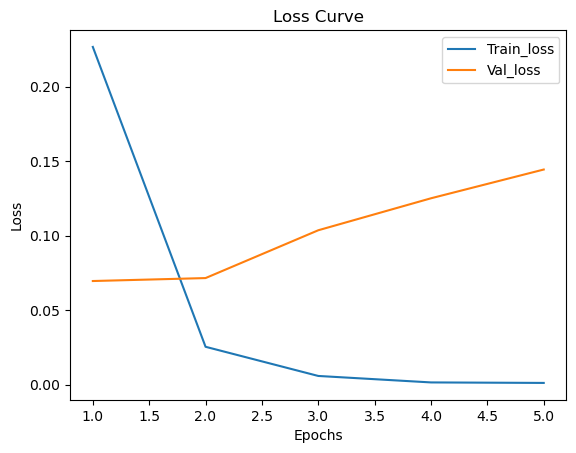

In [19]:
plt.plot(np.arange(1, N_EPOCHS+1), train_losses, label = "Train_loss")
plt.plot(np.arange(1, N_EPOCHS+1), val_losses, label = "Val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

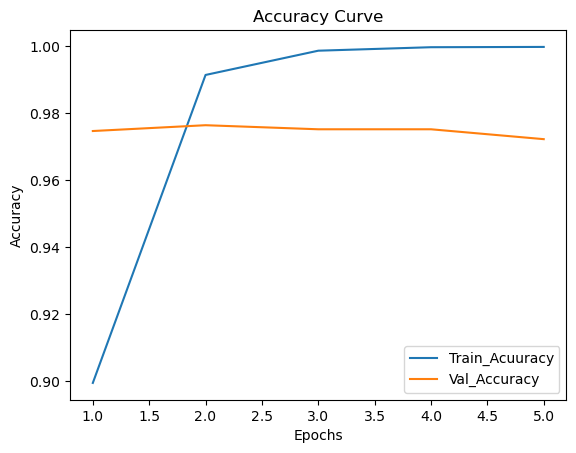

In [20]:
plt.plot(np.arange(1, N_EPOCHS+1), train_accs, label = "Train_Acuuracy")
plt.plot(np.arange(1, N_EPOCHS+1), val_accs, label = "Val_Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

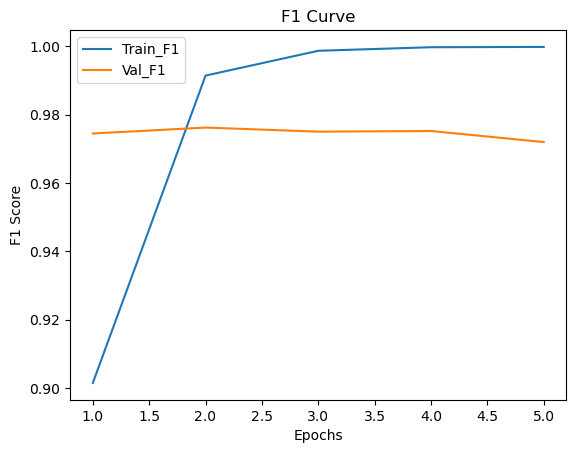

In [21]:
plt.plot(np.arange(1, N_EPOCHS+1), train_f1s, label = "Train_F1")
plt.plot(np.arange(1, N_EPOCHS+1), val_f1s, label = "Val_F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Curve")
plt.legend()
plt.show()

In [22]:
dataset.set_split('test')

test_loss, test_acc, test_f1 = evaluate(model, data_loader, loss_fn)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 66.67it/s]

Test Loss: 0.129 | Test Acc: 97.22% | Test F1: 97.20%
